# Geospatial Validation

@roman 

16 Oct, 2024

Code to remove inconsistent data from geospatial data.


---
# Settings

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import uuid
import os

from INEGIpy import MarcoGeoestadistico
from scipy.spatial.distance import pdist, squareform


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)
geo_framework = MarcoGeoestadistico()

---
# Data

## Properties

In [3]:
# read parquet
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s1.parquet")

# original columns
original_columns = gdf_properties.columns

# to geodataframe
gdf_properties = gpd.GeoDataFrame(
    gdf_properties,
    geometry=gpd.points_from_xy(gdf_properties['longitude'], gdf_properties['latitude']),
    crs='EPSG:4326'
    )

gdf_properties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2259316 entries, 0 to 2259315
Data columns (total 53 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   half_bathrooms                      uint8         
 1   full_bathrooms                      uint8         
 2   property_class_more_common_in_area  string        
 3   neighborhood                        string        
 4   constructor                         string        
 5   zip_code                            uint32        
 6   age_in_months                       uint8         
 7   parking_lots                        uint8         
 8   valuation_date                      datetime64[ns]
 9   potable_water_service_id            float64       
 10  lighting_service_id                 float64       
 11  sidewalk_id                         float64       
 12  project_quality_id                  float64       
 13  property_class_id                 

In [4]:
# look nans
gdf_properties.isna().sum()[gdf_properties.isna().sum() > 0].sort_values(ascending=False)

project_quality_id                  780594
rentable_units_subject_property     780589
current_use                         773565
sidewalk_id                         770490
access_routes                       763709
potable_water_service_id            763678
lighting_service_id                 763650
curb_id                             763650
water_collection_service_id         763650
electrical_supply_service_id        763650
telephone_service_supply_id         763650
public_transportation_service_id    763650
rentable_units                      320234
elevator_service_id                 104579
constructor                           3093
neighborhood                           154
dtype: int64

In [5]:
# see original cols
original_columns

Index(['half_bathrooms', 'full_bathrooms',
       'property_class_more_common_in_area', 'neighborhood', 'constructor',
       'zip_code', 'age_in_months', 'parking_lots', 'valuation_date',
       'potable_water_service_id', 'lighting_service_id', 'sidewalk_id',
       'project_quality_id', 'property_class_id', 'conservation_status_id',
       'controller_id', 'elevator_service_id', 'state_id', 'equipment_id',
       'curb_id', 'infrastructure_service_id', 'road_materials_id',
       'municipality_id', 'grantor_id', 'urban_proximity_id',
       'water_collection_service_id', 'electrical_supply_service_id',
       'telephone_service_supply_id', 'property_type_id',
       'public_transportation_service_id', 'valuation_unit_id',
       'valuation_professional_id', 'latitude', 'longitude', 'level',
       'total_levels', 'purpose_of_appraisal', 'bedrooms', 'built_area',
       'saleable_area', 'land_area', 'rentable_units',
       'rentable_units_subject_property', 'current_use', 'market_pr

## States

In [6]:
# get all mexico states
gdf_mex_states = geo_framework.Entidades()
gdf_mex_states.head()

,geometry,cvegeo,cve_agee,nom_agee,nom_abrev,pob,pob_fem,pob_mas,viv
0,"MULTIPOLYGON (((-102.29739 22.45527, -102.2955...",01,01,Aguascalientes,Ags.,1425607,728924,696683,386671
1,"MULTIPOLYGON (((-114.11561 28.09639, -114.1152...",02,02,Baja California,BC,3769020,1868431,1900589,1149563
2,"MULTIPOLYGON (((-109.89451 22.87476, -109.8946...",03,03,Baja California Sur,BCS,798447,392568,405879,240660
3,"MULTIPOLYGON (((-91.95650 20.19700, -91.95636 ...",04,04,Campeche,Camp.,928363,471424,456939,260824
4,"MULTIPOLYGON (((-102.31549 29.88000, -102.3150...",05,05,Coahuila de Zaragoza,Coah.,3146771,1583102,1563669,901249


<Axes: >

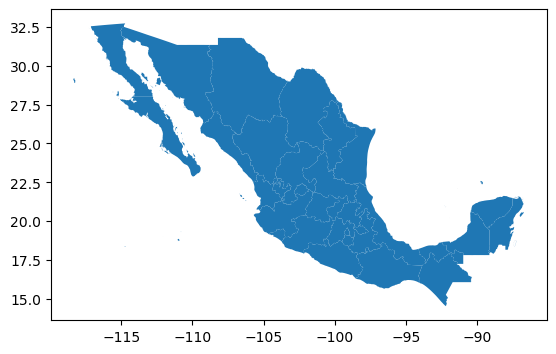

In [7]:
# plot states
gdf_mex_states.plot()

---
# Geospatial Validation

## S1: Points Inside Mexico

### Modify Data

In [8]:
# geodataframe
gdf_properties = (
    gdf_properties
    .assign(
        # in order to be aligned with the INEGI geo framework
        state_id=lambda x: x['state_id'].astype(str).str.zfill(2),
        municipality_id=lambda x: x['municipality_id'].astype(str).str.zfill(3)
    )
)

gdf_properties.loc[:, ['state_id', 'municipality_id']].head()

,state_id,municipality_id
0,07,078
1,31,050
2,31,041
3,31,041
4,31,052


### Spatial Join

In [9]:
# join properties with states, if the point is inside any state
gdf_properties_country_not_match = (
    gpd.sjoin(gdf_properties, gdf_mex_states, predicate='within', how='left')
    # get only the properties that did not match
    .loc[lambda x: x['cvegeo'].isna()]
    )

# print
print(f"Properties that did not match: {gdf_properties_country_not_match.shape[0]}")
print(f"Percentage of properties that did not match: {gdf_properties_country_not_match.shape[0] / gdf_properties.shape[0]}")

Properties that did not match: 57
Percentage of properties that did not match: 2.5228874579740063e-05


<Axes: >

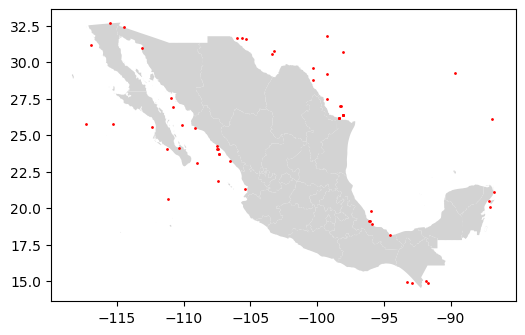

In [10]:
# plot properties that did not match
fig, ax = plt.subplots(figsize=(6, 6))
gdf_mex_states.plot(ax=ax, color='lightgrey')
gdf_properties_country_not_match.plot(ax=ax, color='red', markersize=1)

In [11]:
# clean the properties that did not match
gdf_properties = (
    gdf_properties
    .sjoin(gdf_mex_states, predicate='within', how='inner')
    .drop(columns=['index_right'])
    .loc[:, gdf_properties.columns]
)

In [12]:
# shape
gdf_properties.shape

(2259259, 53)

## S2: Points inside each state 

In [13]:
# join properties with states, if the point is inside any state
gdf_properties_states_not_match = (
    gpd.sjoin(gdf_properties, gdf_mex_states, predicate='within', how='inner')
    .assign(state_id=lambda x: x['state_id'].astype(str).str.zfill(2))
    .query("state_id != cvegeo")
    )

print(f"Properties that did not match: {gdf_properties_states_not_match.shape[0]}")
print(f"Percentage of properties that did not match: {gdf_properties_states_not_match.shape[0] / gdf_properties.shape[0]}")

Properties that did not match: 441
Percentage of properties that did not match: 0.00019519674371110173


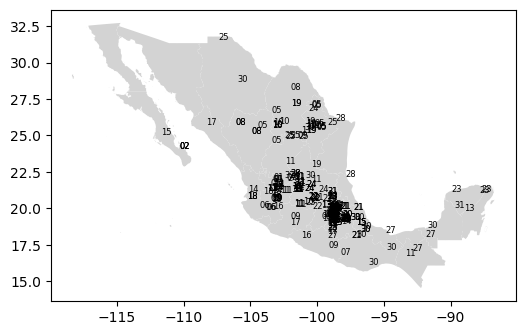

In [14]:
# plot properties that did not match
fig, ax = plt.subplots(figsize=(6, 6))
gdf_mex_states.plot(ax=ax, color='lightgrey')

# plot
for idx, row in gdf_properties_states_not_match.iterrows():
    ax.text(row.geometry.x, row.geometry.y, row['state_id'], fontsize=6)

In [15]:
# clean the properties that did not match
gdf_properties = (
    gpd.sjoin(gdf_properties, gdf_mex_states, predicate='within', how='inner')
    .query("state_id == cvegeo")
    .drop(columns=['index_right'])
    .loc[:, gdf_properties.columns]
)
# print
gdf_properties.shape

(2258818, 53)

## S3: Points inside each municipality

In [16]:
def process_id_entidad(id_entidad, gdf_properties):
    """
    Process the GeoDataFrame for a given id_entidad and save the result.

    Parameters:
    - id_entidad (str): The id_entidad to process.
    - gdf_properties (GeoDataFrame): The GeoDataFrame of properties.
    """
    # Get municipalities of the state
    gdf_mun = geo_framework.Municipios(id_entidad)

    # Filter and join GeoDataFrames
    gdf_result = (
        gdf_properties
        .query("state_id == @id_entidad")
        .sjoin(gdf_mun, how='left', predicate='within')
        .query("municipality_id != cve_agem")
    )

    return gdf_result

# process
entity_list = gdf_properties['state_id'].unique()
wrong_mun_gdf = []

for entity in tqdm(entity_list):
    wrong_mun_gdf.append(process_id_entidad(entity, gdf_properties))


100%|██████████| 32/32 [05:51<00:00, 10.97s/it]


In [17]:
# concat
gdf_properties_wrong_mun = pd.concat(wrong_mun_gdf)

# print
print(f"Properties that did not match: {gdf_properties_wrong_mun.shape[0]}")
print(f"Percentage of properties that did not match: {gdf_properties_wrong_mun.shape[0] / gdf_properties.shape[0]}")

Properties that did not match: 26344
Percentage of properties that did not match: 0.011662736882741328


<Axes: >

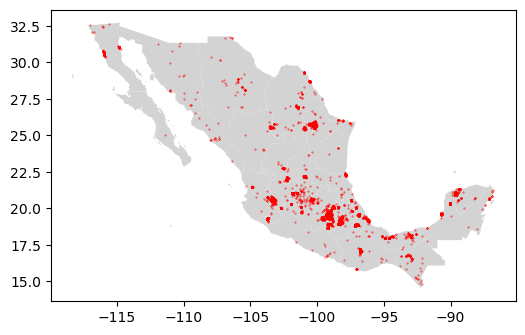

In [18]:
# plot
fig, ax = plt.subplots(figsize=(6, 6))
gdf_mex_states.plot(ax=ax, color='lightgrey')
gdf_properties_wrong_mun.plot(ax=ax, color='red', markersize=0.1)

In [19]:
# clean the properties that did not match
index_unwanted = gdf_properties_wrong_mun.index

# drop
gdf_properties = gdf_properties.drop(index_unwanted, axis=0)

# print
gdf_properties.shape

(2232474, 53)

---
# Save

In [20]:
# subset
gdf_properties = gdf_properties[list(original_columns)]

# save
os.makedirs("../../data/interim", exist_ok=True)
gdf_properties.to_parquet("../../data/interim/cleaned_data_s2.parquet")

---
# Sandbox

In [21]:
# crs
gdf_properties_wrong_mun

,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,geometry,index_right,cvegeo,cve_agee,cve_agem,nom_agem,cve_cab,pob,pob_fem,pob_mas,viv,nom_cab
11868,0,2,2,EL PARRAL,NO APLICA,30530,240,3,2022-05-25,NaN,NaN,NaN,NaN,2,4,d92eb331-b5b7-49f6-962b-d7798c9f11bd,0.0,07,3,NaN,3,1,107,b7e7091c-2a1b-496a-8a7d-925a1406f820,2,NaN,NaN,NaN,2,NaN,90a0a9f7-fab3-4170-b3da-db49e122e41b,fb885b78-da90-4775-8d46-a4aa22329290,16.368050,-93.003364,3,2,S/D,5,250.380005,297.510010,334.000000,1.0,NaN,<NA>,1851000.0,1851000.0,1405013.40,3.077810e+05,<NA>,30,88556b4b-2205-46a3-b198-54eb2efdb9d4,9ace0a25-511b-5e5c-90ef-7538ae0ef37d,POINT (-93.00336 16.36805),45,07122,07,122,El Parral,0001,15587,7996,7591,4266,El Parral
26377,0,3,3,PLAN DE AYALA,NO APLICA,29020,240,1,2022-08-25,1.0,2.0,1.0,1.0,3,5,760f7c71-dfdb-4662-914d-c38d96ebc360,2.0,07,1,1.0,3,3,101,9a2781c9-b312-453c-86d1-a6e90584a083,3,2.0,1.0,1.0,2,1.0,d2192979-5dc6-458c-9a1b-b0142944e5e6,d3bdaf3c-9cca-43d5-836b-de1130c85531,16.783660,-93.214230,3,2,S/D,4,234.449997,287.820007,196.960007,1.0,1.0,HABITACIONAL CASA HABITACIÓN DE DOS NIVELES QU...,2940000.0,2940000.0,1947320.80,6.184544e+05,COMO VÍA PRINCIPAL SE ENCUENTRA EL LIBRAMIENTO...,40,0781fbb1-6431-4307-ad51-065dcd04ad6e,95df6fa8-d552-57e4-a4a4-950ddd4550c4,POINT (-93.21423 16.78366),92,07012,07,012,Berriozábal,0001,64632,32718,31914,16200,NaN
33237,0,1,4,PLAN DE AYALA,NO APLICA,29020,0,1,2022-05-10,NaN,NaN,NaN,NaN,4,6,9da8b81a-0164-42f5-af10-3d9aa54c27df,0.0,07,4,NaN,3,2,101,9a2781c9-b312-453c-86d1-a6e90584a083,3,NaN,NaN,NaN,2,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,0cea4ed2-0ca9-44a2-8e6b-fe00ad780679,16.782489,-93.211367,3,2,S/D,2,172.130005,234.000000,117.000000,1.0,NaN,<NA>,3603600.0,3604000.0,2543860.00,4.329000e+05,<NA>,70,15dc8b29-9a3d-4e88-9369-7b444612e517,0d52bd19-28de-58a6-ab6a-b97cfc1841db,POINT (-93.21137 16.78249),92,07012,07,012,Berriozábal,0001,64632,32718,31914,16200,NaN
46863,0,1,3,JARDINES DEL GRIJALVA,NO APLICA,29165,144,1,2022-11-16,NaN,NaN,NaN,NaN,3,4,f12b771c-da12-4cb0-9e83-1b599dd35a55,2.0,07,4,NaN,3,3,027,01c8bed5-4e5c-44b6-8346-5081a32429d5,3,NaN,NaN,NaN,2,NaN,911df39d-af2d-4a7d-a7ab-ecdffa8e5be8,7c7685fe-224c-4cc6-9794-81cc5c8495e7,16.729652,-93.039216,3,1,S/D,2,51.000000,51.000000,90.000000,1.0,NaN,<NA>,640000.0,640000.0,312650.40,2.250000e+05,<NA>,48,6d7b76cc-6e15-4740-83ce-52d423405a46,f35aa6e9-8123-5352-9b70-22a468dca103,POINT (-93.03922 16.72965),43,07101,07,101,Tuxtla Gutiérrez,0001,604147,316623,287524,166210,NaN
53665,0,1,3,LA MISION,NO APLICA,29096,48,1,2022-12-23,1.0,2.0,1.0,1.0,3,4,689c1616-f11f-4de7-9370-b86e4a40c1d2,2.0,07,4,1.0,3,3,101,01c8bed5-4e5c-44b6-8346-5081a32429d5,3,1.0,1.0,1.0,2,1.0,3455ac2f-0f85-4041-a48d-6214eb30588b,c49d6006-68a3-4968-bbdd-9976f26517ba,16.795371,-93.262143,3,2,S/D,3,138.720001,138.720001,90.000000,1.0,1.0,CASA HABITACION,1500000.0,1500000.0,1090755.28,3.269772e+05,LIB. SUR. OTE. DE PRIMER ORDEN Y ALTO FLUJO VE...,56,5ac03162-68e5-43c1-a221-9da4a128c88e,078f8221-843a-5564-b022-82b1e599fa93,POINT (-93.26214 16.79537),92,07012,07,012,Berriozábal,0001,64632,32718,31914,16200,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.